# Sentiment Analysis P3

In this notebook, you will learn how to build a deep LSTM network and how to insert a fixed pre-trained embedding layer in Keras

<img src="resources/pipeline.png" width="800px">

## Still Emoji

In [28]:
# import 
import numpy as np
import utils
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Embedding
from tensorflow.keras.preprocessing import sequence

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'


np.random.seed(1)

In [36]:
train_x, test_x, train_y, test_y = utils.load_emoji()

In [37]:
train_x.shape

(132,)

In [38]:
train_x[1:5]

array(['I am proud of your achievements',
       'It is the worst day in my life', 'Miss you so much',
       'food is life'], dtype='<U52')

In [39]:
test_x[1:5]

array(['he did not answer\t', 'he got a very nice raise\t',
       'she got me a nice present\t', 'ha ha ha it was so funny\t'],
      dtype='<U38')

In [40]:
test_y[1:5]

array([3, 2, 2, 2])

In [41]:
train_y[1:5]

array([2, 3, 0, 4])

In [42]:
train_y.shape

(132,)

**Load pretrained word embeddings**

2 dictionaries are loaded:

- `word_to_index`: map a word to its index in the vocabulary
    - Example:  `'word' -> 1234`

- `word_to_vec_map`: map a word to its embedding
    - Example: `'word' -> [0.1, 0.2, ..., 0.45]`

When adding a custom embedding layer in Keras, we can only load the pretrained embedding as a big matrix instead of a dictionary. An index will help us locate the entry for a given word.

### Word Embeddings & One Hot

In [43]:
word_to_index, word_to_vec_map = utils.load_glove_vecs()
#connect the indices in the dataset to the dictionary in the package

data already available, skip downloading.
loading glove... this may take a while...
glove loaded successfully.


In [44]:
utils.sentences_to_indices?

In [45]:
# Convert word to the index in vocabulary
utils.sentences_to_indices(
    np.array(["i like it", "i hate it"]),  # array of test sentences
    word_to_index, 
    max_len = 10)#max_len以最长的句子有几个单词为准
#Return a array of indices of a given sentence. The sentence will be trimed/padded to max_len
#utils.sentences_to_indices(X, word_to_index, max_len)
#Return: indices (np.ndarray): the shape is (m, max_len) where m is the number of sentences建立到单词表的索引，不是embeddng
#word index->mapped to word_to_index->connect to word_to_vec_map later

array([[185457., 222471., 193716.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.],
       [185457., 174339., 193716.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.]])

In [46]:
maxlen = max([len(x.split()) for x in train_x])
print('max number of words in a sentence:', maxlen)

max number of words in a sentence: 10


In [27]:
utils.convert_to_one_hot?

In [47]:
# Convert training/testing features into index list
train_x = utils.sentences_to_indices(train_x, word_to_index, maxlen)
test_x = utils.sentences_to_indices(test_x, word_to_index, maxlen)

# Convert training/testing labels into one hot array
train_y = utils.convert_to_one_hot(train_y, C = 5)
test_y = utils.convert_to_one_hot(test_y, C = 5)

In [49]:
# Check to make sure the shape looks good
assert train_x.shape == (132, maxlen)
assert train_y.shape == (132, 5)

### Embedding Layer

We need to build a embedding matrix where each row represent a word vector.

In [51]:
#自己写一个embedding layer嵌入到神经网络中

def pretrained_embedding_layer(word_to_index, word_to_vec_map):
    """
    Build and return a Keras Embedding Layer given word_to_vec mapping and word_to_index mapping
    
    Args:
        word_to_index (dict[str->int]): map from a word to its index in vocabulary
        word_to_vec_map (dict[str->np.ndarray]): map from a word to a vector with shape (N,) where N is the length of a word vector (50 in our case)

    Return:
        Keras.layers.Embedding: Embedding layer
    """
    
    # Keras requires vocab length start from index 1
    vocab_len = len(word_to_index) + 1  
    emb_dim = list(word_to_vec_map.values())[0].shape[0]
    
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    return Embedding(
        input_dim=vocab_len, #输入是单词表的长度
        output_dim=emb_dim, #输出为具体的embedding的长度，在这为50
        trainable=False,  # Indicating this is a pre-trained embedding 固定embedding这一层不要再训练的时候改变
        weights=[emb_matrix]) #每一行对应句子中每一个单词对应的embedding，#of words x length of embedding

For more information on how to define a pre-trained embedding layer in Keras, please refer to [this post](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html).

### Build the Model

<img src="resources/deep_lstm.png" style="width:700px;height:400px;"> <br>
<caption><center> A 2-layer LSTM sequence classifier. </center></caption>

In [52]:
def build_emoji_model(input_dim, word_to_index, word_to_vec_map):
    """
    Build and return the Keras model
    
    Args:
        input_dim: The dim of input layer
        word_to_vec_map (dict[str->np.ndarray]): map from a word to a vector with shape (N,) where N is the length of a word vector (50 in our case)
        word_to_index (dict[str->int]): map from a word to its index in vocabulary
    
    Returns:
        Keras.models.Model: 2-layer LSTM model
    """
    
    # Input layer
    sentence_indices = Input(shape=(input_dim,), dtype='int32')
    
    # Embedding layer
    embedding_layer = pretrained_embedding_layer(word_to_index, word_to_vec_map)
    embeddings = embedding_layer(sentence_indices)   
    
    # 2-layer LSTM
    X = LSTM(128, return_sequences=True, recurrent_dropout=0.5)(embeddings)  # N->N RNN 
    #128-LSTM内部用来储存信息的向量的长度
    #return_sequences=True 如果不为true 则仅保留做后一个黄色盒子
    #dropout是一个常见的用来防治overfitting 的手段 0.3 0.5都常见
    X = Dropout(rate=0.8)(X)
    X = LSTM(128, recurrent_dropout=0.5)(X)  # N -> 1 RNN
    X = Dropout(rate=0.8)(X)
    X = Dense(5, activation='softmax')(X)
    #recurencee dropout横向 dropout纵向
    # Create and return model
    model = Model(inputs=sentence_indices, outputs=X)
    
    return model

In [56]:
emoji_model = build_emoji_model(
    maxlen, 
    word_to_index, 
    word_to_vec_map)

emoji_model.summary()
#since most variables of 20,223,927 are from embedding, we only need to train 223,877 variables

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 128)           91648     
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645 

In [57]:
emoji_model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'])

In [58]:
history = emoji_model.fit(
    train_x, 
    train_y, 
    epochs = 100,  
    shuffle=True,
    validation_data=[test_x, test_y]
)

Train on 132 samples, validate on 56 samples
Epoch 1/100
132/132 [==============================] - 2s 14ms/sample - loss: 1.6192 - acc: 0.2121 - val_loss: 1.5702 - val_acc: 0.3036
Epoch 2/100
132/132 [==============================] - 0s 1ms/sample - loss: 1.5747 - acc: 0.2727 - val_loss: 1.5495 - val_acc: 0.3036
Epoch 3/100
132/132 [==============================] - 0s 2ms/sample - loss: 1.5489 - acc: 0.3333 - val_loss: 1.5360 - val_acc: 0.3214
Epoch 4/100
132/132 [==============================] - 0s 1ms/sample - loss: 1.5589 - acc: 0.2955 - val_loss: 1.5208 - val_acc: 0.3571
Epoch 5/100
132/132 [==============================] - 0s 2ms/sample - loss: 1.5243 - acc: 0.3561 - val_loss: 1.5033 - val_acc: 0.4464
Epoch 6/100
132/132 [==============================] - 0s 1ms/sample - loss: 1.5302 - acc: 0.2576 - val_loss: 1.4868 - val_acc: 0.4821
Epoch 7/100
132/132 [==============================] - 0s 2ms/sample - loss: 1.4928 - acc: 0.3788 - val_loss: 1.4649 - val_acc: 0.5536
Epoch 8/1

Epoch 61/100
132/132 [==============================] - 0s 1ms/sample - loss: 0.2478 - acc: 0.9394 - val_loss: 0.3118 - val_acc: 0.9107
Epoch 62/100
132/132 [==============================] - 0s 1ms/sample - loss: 0.3096 - acc: 0.9091 - val_loss: 0.2687 - val_acc: 0.8750
Epoch 63/100
132/132 [==============================] - 0s 1ms/sample - loss: 0.3204 - acc: 0.9091 - val_loss: 0.3120 - val_acc: 0.8571
Epoch 64/100
132/132 [==============================] - 0s 1ms/sample - loss: 0.2421 - acc: 0.9167 - val_loss: 0.3075 - val_acc: 0.8750
Epoch 65/100
132/132 [==============================] - 0s 1ms/sample - loss: 0.1695 - acc: 0.9470 - val_loss: 0.3614 - val_acc: 0.8214
Epoch 66/100
132/132 [==============================] - 0s 1ms/sample - loss: 0.2106 - acc: 0.9318 - val_loss: 0.5153 - val_acc: 0.8214
Epoch 67/100
132/132 [==============================] - 0s 1ms/sample - loss: 0.2686 - acc: 0.9015 - val_loss: 0.3443 - val_acc: 0.8571
Epoch 68/100
132/132 [==========================

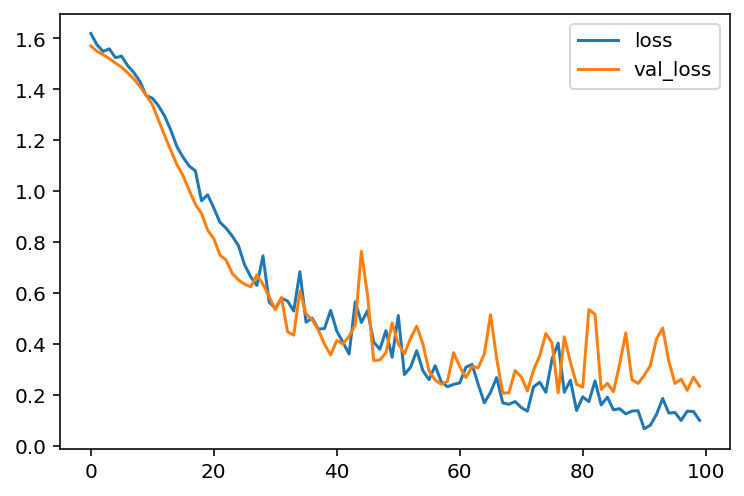

In [59]:
utils.plot_history(history, ['loss', 'val_loss'])
#tenserflow check point/self-write a hook to stop at the best echo

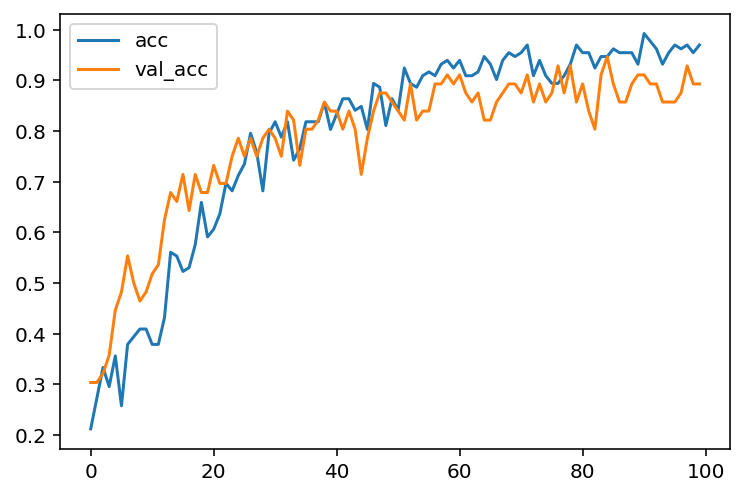

In [60]:
utils.plot_history(history, ['acc', 'val_acc'])

In [61]:
emoji_model.evaluate(train_x, train_y)
emoji_model.evaluate(test_x, test_y)

56/56 [==============================] - 0s 329us/sample - loss: 0.2349 - acc: 0.8929


[0.2348529047199658, 0.89285713]

### Sava and Load Models

In [62]:
# import
import h5py

Two parts need to be saved inorder to use the model in prod:

1. Neural Network Structure
2. Trained Weights (Matrix)

We will save them separately. This makes it easy to manage multiple versions of weights and you can always choose which version to go for production.

In [63]:
import os

model_root = 'resources/emoji_model'
os.makedirs(model_root, exist_ok=True)

In [64]:
# Save model structure as json
with open(os.path.join(model_root, "network.json"), "w") as fp:
    fp.write(emoji_model.to_json())

# Save model weights
emoji_model.save_weights(os.path.join(model_root, "weights.h5"))

Download and load a pretrained model 

In [65]:
network_path, weights_path = utils.download_best_emoji_model()

start downloading...
start extracting compressed files...
data files are now available at resources/emoji_model_best


In [66]:
from tensorflow.keras.models import model_from_json

# Load model structure
with open(network_path, "r") as fp:
    emoji_model_best = model_from_json(fp.read())#model_from_json load model and set up the structure

# Load model weights
emoji_model_best.load_weights(weights_path)#load weights

In [67]:
#compile model into binary to speed up the process
#still need to compile a pretrained model
emoji_model_best.compile( 
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'])

In [68]:
emoji_model_best.evaluate(train_x, train_y)
emoji_model_best.evaluate(test_x, test_y)

56/56 [==============================] - 0s 596us/sample - loss: 0.2815 - acc: 0.9286


[0.2815101998192923, 0.9285714]

In [69]:
def predict(text):
    x = utils.sentences_to_indices(
        np.array([text]), 
        word_to_index, 
        maxlen)
    
    probs = emoji_model_best.predict(x)
    pred = np.argmax(probs)
    
    print(text, utils.label_to_emoji(pred))

In [70]:
predict('i am not feeling happy')
#sequence model can detect the effect of NOT on later part of the sentence

i am not feeling happy 😞


## Mission Impossible

<img src="resources/imf.png" width="100px">

Now you've learned all the necessary building blocks for doing sentiment analysis, from the data preprocessing pipeline, the simple NB model, to the SOTA deep LSTM network. Now it's time for you to take a challenge!


Your mission, should you choose to accept it, is to apply what we've learned and apply it to the IMDB dataset. You may write your own script for doing preprocessing, choose any models you like. You may also use any types of word embeddings (`Word2Vec`, `Spacy`, `FastText`), or even character level embeddings! Only the sky is the limit.

The challenge is simple, **boost the accuracy on test dataset to above 90%**, which is 7% higher than our baseline model (MNB). If you make it, it will be a pretty strong indicator to prove that you've understand the data and the pipeline well, knowing where the bottleneck is and how to overcome it. 

As always, should you or any of your IM Force be caught or killed, the Secretary will disavow any knowledge of your actions. This notebook will self-destruct in five minutes. Good luck.

5, 4, 3, 2, 1... No it will not self-destruct, I'm just kidding 😛

### Some hints:

1. Think about what information are missing during preprocessing. (e.g.: checkout `stopwords`)
2. Should we limit the vocabulary even if we're using embedding?
3. If so, how should we handle OOV word?
4. How to choose the number of layers and number of units for LSTM?
5. Need GPU? Colab or FloydHub is your friend! (Though I don't think it will make a real difference on NLP tasks.)

> Please try your best as practice is the only way to understand something. But don't worry too much, I'll post my solution in a week :) 